In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
currentDir = os.path.dirname(os.path.abspath(__name__))
relativePath = 'ethData/ETHUSDT_1d.csv'
file_path= os.path.join(currentDir, relativePath)
df = pd.read_csv(file_path)
lenDataPoints = len(df)
from untrade.client import Client
import warnings
warnings.filterwarnings("ignore")

In [2]:
def sma(m,n):
    s = 0
    for i in range(1, n+1):
        s += df['close'][m - i]
    s /= n
    return s

def ema(n):
    emaList = [0] * (n - 1)
    sma_ = sum(df['close'][:n]) / n
    emaList.append(sma_)
    k = 2/(n+1)
    for i in range(n, lenDataPoints):
        emaList.append(df['close'][i]*k + emaList[-1]*(1 - k))
    return emaList

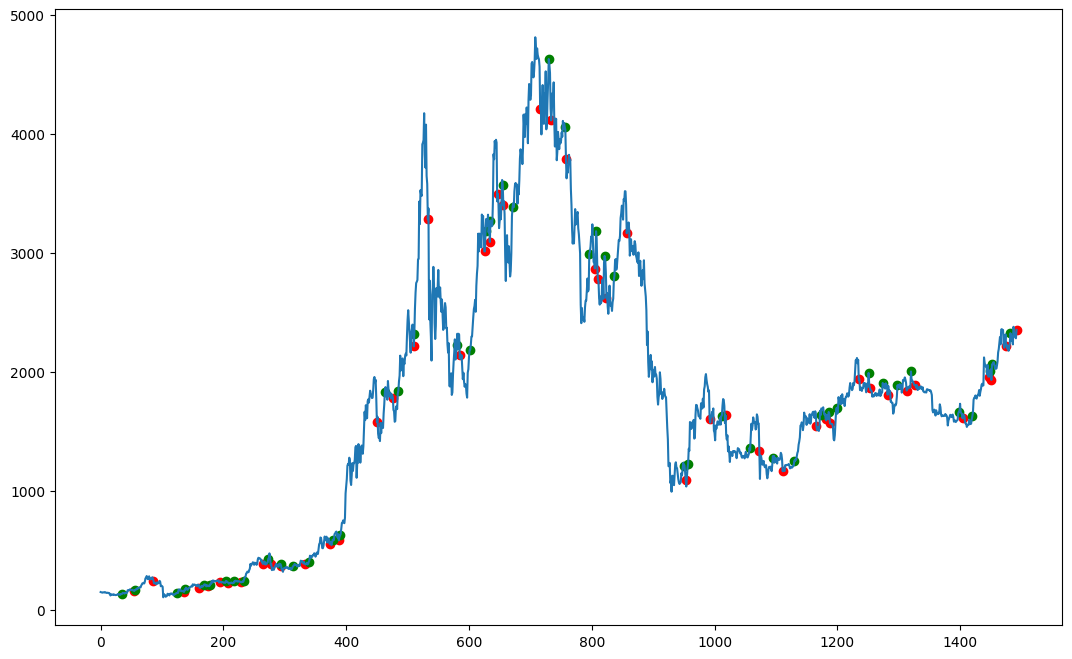

In [3]:
blue = ema(13)
red = ema(8)
green = ema(5)

check1 = 0
check2 = 0

signal = [0] * 13
for i in range(13, lenDataPoints):
    if blue[i] < red[i] < green[i]:
        if check1 == 0:
            signal.append(1)
            check1 = 1
        else:
            signal.append(0)
    else:
        if check1 == 1:
            signal.append(-1)
            check1 = 0
        else:
            signal.append(0)

if check1 == 1:
    check1 = 0
    signal[-1] = -1

df['signals'] = signal

plt.figure(figsize=(13,8))
l = list(range(lenDataPoints))
red_days = [i for i in range(lenDataPoints) if signal[i] == -1]          #long square-off
red_values = [df['close'][i] for i in range(lenDataPoints) if signal[i] == -1]      #long square-off
green_days = [i for i in range(lenDataPoints) if signal[i] == 1]         #long start
green_values = [df['close'][i] for i in range(lenDataPoints) if signal[i] == 1]     #long start
plt.plot(red_days, red_values, 'ro')
plt.plot(green_days, green_values, 'go')
plt.plot(df['close'])
plt.show()

In [4]:
def perform_backtest(csv_file_path):
    client = Client()
    result = client.backtest(
        jupyter_id="akshatrai",
        file_path=csv_file_path,
        leverage=1,
    )
    return result

In [5]:
df = df.rename(columns={'Unnamed: 0': 'days'})
df.to_csv('signals.csv')
for i in range(len(df)):
    if df.loc[i, 'signals'] == 2 :
        df.loc[i, 'signals'] = -1
    elif df.loc[i, 'signals'] == -2 :
        df.loc[i, 'signals'] = 1
data = df[df['signals'] != 0]
res = data
res.to_csv("processed_data.csv", index=False)

csv_file_path = "processed_data.csv"
backtest_result = perform_backtest(csv_file_path)
last_value = None
for value in backtest_result:
    print(value)
    last_value = value

data: {
  "jupyter_id": "akshatrai",
  "result_type": "Main",
  "message": "Backtest completed",
  "result": {
    "static_statistics": {
      "From": "2020-01-04 00:00:00",
      "Total Trades": 48,
      "Leverage Applied": 1.0,
      "Winning Trades": 21,
      "Losing Trades": 27,
      "No. of Long Trades": 48,
      "No. of Short Trades": 0,
      "Benchmark Return(%)": 1655.345162,
      "Benchmark Return(on $1000)": 16553.451618,
      "Win Rate": 43.75,
      "Winning Streak": 4,
      "Losing Streak": 5,
      "Gross Profit": 4460.399133,
      "Net Profit": 4388.399133,
      "Average Profit": 91.424982,
      "Maximum Drawdown(%)": 8.863356,
      "Average Drawdown(%)": 2.041492,
      "Largest Win": 1517.314375,
      "Average Win": 278.738572,
      "Largest Loss": -128.794086,
      "Average Loss": -54.263366,
      "Maximum Holding Time": "60 days 0:0:0",
      "Average Holding Time": "15 days 8:0:0",
      "Maximum Adverse Excursion": 26.845672,
      "Average Adverse

In [6]:
import talib

In [7]:
###BACKTESTING#####
def Backtest(df_1):
    df_1['signal'] = df_1['signals']
    df_1.to_csv('signals.csv')
    dg = df_1[df_1['signal'] != 0]
    

    dg['entry_price'] = dg['close']
    dg['entry_timestamp'] = dg['datetime']
    dg['exit_price'] = dg['entry_price'].shift(-1)
    dg['exit_timestamp'] = dg['datetime'].shift(-1)
    pnl = dg[dg['signal'] > 0][['entry_timestamp', 'entry_price', 'exit_timestamp', 'exit_price', 'signal']]


    ##for static statistics

    pnl['profit_per_btc'] = np.where(pnl['signal'] == 1, pnl['exit_price'] - pnl['entry_price'], 
                                    np.where(pnl['signal'] == 2, pnl['entry_price'] - pnl['exit_price'], None)) 
    pnl['capital'] = 1000
    pnl['#units'] = pnl['capital'] / pnl['entry_price']
    pnl['profit_per_capital'] = pnl['#units'] * pnl['profit_per_btc']
    pnl['tnc_cost'] = 1.5
    pnl['profit_after_tnc'] = pnl['profit_per_capital'] - pnl['tnc_cost']
    pnl['cumulative_profit'] = pnl['profit_after_tnc'].cumsum()
    pnl['roe_%'] = (pnl['profit_after_tnc'] / pnl['capital']) * 100
    net_pnl = pnl.reset_index()
    n_trades = pnl.shape[0]
    pnl['c_f'] = pnl['cumulative_profit'] + 1000
    peak = 1000
    max_drawdown = 0
    for value in pnl['c_f']:
        if value > peak:
            peak = value
        drawdown = (peak - value) / peak
        if drawdown > max_drawdown:
            max_drawdown = drawdown

    max_drawdown_percentage_static = max_drawdown * 100

    ##for compounding statistics
    d = dg[dg['signal'] > 0][['entry_timestamp', 'entry_price', 'exit_timestamp', 'exit_price', 'signal']]
    d['profit_per_eth'] = np.where(d['signal'] == 1, d['exit_price'] - d['entry_price'], 
                                                np.where(d['signal'] == 2, d['entry_price'] - d['exit_price'], None))
    d['tnc_cost'] = 1.5
    d['capital'] = 1000
    d['units'] = 1000 / d['entry_price']
    d['profit_per_capital'] = d['units'] * d['profit_per_eth']
    d['profit_after_tnc'] = d['profit_per_capital'] - d['tnc_cost']
    #d['cumulative_profit'] = 0
    
    for i in tqdm(range(1, len(d))):
        d['capital'].iloc[i] = d['capital'].iloc[i - 1] + d['profit_after_tnc'].iloc[i - 1]
        d['capital'].iloc[i]/=1.0015
        d['units'].iloc[i] = d['capital'].iloc[i] / d['entry_price'].iloc[i]
        d['profit_per_capital'].iloc[i] = d['units'].iloc[i] * d['profit_per_eth'].iloc[i]
        d['profit_after_tnc'].iloc[i] = d['profit_per_capital'].iloc[i] - d['tnc_cost'].iloc[i]
        #d['cumulative_profit'].iloc[i] = d['capital'].iloc[i-1] + d['cumulative_profit'].iloc[i] + d['profit_after_tnc'].iloc[i]

    d['c_f'] = d['capital']
    peak = 1000
    max_drawdown = 0
    max_dd_trade_time = 0
    max_dd_index = 0 

    for i, value in enumerate(d['c_f']):
        if value > peak:
            peak = value
        drawdown = (peak - value) / peak
        if drawdown > max_drawdown:
            max_drawdown = drawdown
            max_dd_index = i

    max_drawdown_percentage_compounding = max_drawdown * 100

    return net_pnl, net_pnl['profit_after_tnc'].sum(), max_drawdown_percentage_static, n_trades, max_drawdown_percentage_compounding, max_dd_index 

In [8]:
obj, net_pnl_amount, max_drawdown_percentage_static, n_trades, max_drawdown_percentage_compounding, max_dd_index = Backtest(df)

obj.to_csv('pnl_since_2019.csv', index=False)

print("pnl :", net_pnl_amount)
print("n_trades:", n_trades)
print("Max_dd_s:", max_drawdown_percentage_static)
print("Max_dd_comp", max_drawdown_percentage_compounding)
print("Max_dd_trade", max_dd_index)

100%|██████████| 47/47 [00:00<00:00, 324.99it/s]

pnl : 4388.399132788378
n_trades: 48
Max_dd_s: 8.863356348583082
Max_dd_comp 39.358073504324736
Max_dd_trade 29
